In [1]:
import os
import pandas as pd
import janitor
import numpy as np


dfs = {}

ruta = os.path.join('..', 'data')

years = range(2019, 2024)

for year in years:
    file_path = os.path.join(ruta, f'{year}clean.csv')  # crea la ruta al archivo
    dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario

df2019 = dfs['df2019']
df2020 = dfs['df2020']
df2021 = dfs['df2021']
df2022 = dfs['df2022']
df2023 = dfs['df2023']
df2019['año']=2019
df2020['año']=2020
df2021['año']=2021
df2022['año']=2022
df2023['año']=2023

for name, df in dfs.items():
    dfs[name] = df.clean_names()


/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_4661/387917906.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_4661/387917906.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_4661/387917906.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_4661/387917906.py:15: DtypeWarning: Columns (6,20,42,43) have mixed typ

In [2]:
# Crear una lista de dataframes
dfs_list = [dfs[name] for name in dfs.keys()]

# Concatenar todos los dataframes
contratos_df = pd.concat(dfs_list, ignore_index=True)

contratos_df.rename(columns={'ano':'año'}, inplace = True)

In [3]:
from currency_converter import CurrencyConverter


for column in contratos_df.columns:
    if contratos_df[column].dtype == 'object':
        contratos_df[column] = contratos_df[column].str.upper()


for column in contratos_df.columns:
    if contratos_df[column].dtype == 'string':
        contratos_df[column] = contratos_df[column].str.upper()

c = CurrencyConverter()
currencies=['USD', 'CAD', 'EUR', 'GBP', 'JPY']

# Create a dictionary to store conversion rates
conversion_rates = {}

for m in currencies:
    conversion_rate = c.convert(1, m, 'MXN')
    print(1, m, "=", conversion_rate, 'MXN')
    conversion_rates[m] = conversion_rate

# Apply conversion rates
contratos_df["importe"] = contratos_df["importe_del_contrato"]

for currency, conversion_rate in conversion_rates.items():
    contratos_df.loc[contratos_df['moneda_del_contrato'] == currency , 'importe'] = contratos_df.loc[contratos_df['moneda_del_contrato'] == currency , "importe_del_contrato"] * conversion_rate

print('Done')


1 USD = 17.115130976369297 MXN
1 CAD = 13.018183084854396 MXN
1 EUR = 18.6863 MXN
1 GBP = 21.75912340762477 MXN
1 JPY = 0.11946998273767662 MXN
Done


In [4]:

def correct_swap(df):
    # Define un patrón de RFC válido
    rfc_pattern = r"^[A-ZÑ&]{3,4}[0-9]{2}(0[1-9]|1[0-2])(0[1-9]|1[0-9]|2[0-9]|3[0-1])[A-Z0-9]?[A-Z0-9]?[0-9A]$"

    # Rellena los NaN con una cadena vacía para poder aplicar str.match
    df.fillna("", inplace=True)

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es un RFC válido
    mask_invalid = ~df['rfc'].str.match(rfc_pattern) & df['proveedor_o_contratista'].str.match(rfc_pattern)

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas
    df.loc[mask_invalid, 'rfc'], df.loc[mask_invalid, 'proveedor_o_contratista'] = df.loc[mask_invalid, 'proveedor_o_contratista'], df.loc[mask_invalid, 'rfc']

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es una cadena vacía
    mask_invalid_empty = ~df['rfc'].str.match(rfc_pattern) & (df['proveedor_o_contratista'] == "")

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas y asigna un valor artificial a 'rfc'
    df.loc[mask_invalid_empty, 'rfc'], df.loc[mask_invalid_empty, 'proveedor_o_contratista'] = 'XAXX010101000', df.loc[mask_invalid_empty, 'rfc']

    # Reemplaza las cadenas vacías con NaN de nuevo
    df.replace("", np.nan, inplace=True)

    return df

# Supón que contratos_df es tu DataFrame original
contratos_df = correct_swap(contratos_df)


In [5]:
def verify_correction(df):
    # Identificar filas donde rfc tiene una longitud distinta a 13
    mask = df['rfc'].str.len() != 12
    # Retornar filas donde rfc tiene una longitud distinta a 13
    return df.loc[mask]

verify_correction(contratos_df[['rfc', 'proveedor_o_contratista']])

,rfc,proveedor_o_contratista
14895,XAXX010101000,ARBAVEL A.C.
16833,XAXX010101000,JESUS GARCIA
16973,XAXX010101000,DAVID ROMERO
21692,XAXX010101000,CRUZ ROBLEDO
23257,XAXX010101000,PAVLO GETMAN
...,...,...
471121,XAXX010101000,FRANCISCO JAVIER MONROY SANCHEZ
471122,XAXX010101000,ALEXIA ANAEL AVILA SOLIS
471137,XAXX010101000,JOSE DE JESUS DIAZ CORONA
471138,XAXX010101000,TOMAS ESPINOZA BENAVIDES


In [6]:
contratos_df['siglas_de_la_institucion'].unique()

array(['COAH', 'OAX', 'IMSS', 'NOTIMEX', 'LICONSA', 'HJM', 'SSA',
       'INDAABIN', 'IPICYT', 'INAPESCA', 'ASA', 'HIM', 'NL', 'CMM',
       'CRAE', 'FONHAPO', 'FGR', 'CONALITEG', 'HGM', 'ININ', 'SADER',
       'CONAGUA', 'CONUEE', 'ISSSTE', 'INEA', 'IMT', 'CONAFE', 'HRAEO',
       'PROFEPA', 'AGN', 'CONAFOR', 'CAPUFE', 'SICT', 'INMEGEN', 'POI',
       'DICONSA', 'CINVESTAV', 'CNBBBJ', 'PR', 'INDESOL', 'RAN', 'AGS',
       'INALI', 'API-COATZACOALCOS', 'CULTURA', 'INEGI', 'GTO', 'MEX',
       'SEDENA', 'SON', 'TFJA', 'CENAM', 'CHIH', 'CIAD', 'VER', 'BC',
       'CIATEQ', 'SAP', 'IFT', 'DGO', 'COFECE', 'TAMPS', 'COLPOS',
       'INAOE', 'CIDETEQ', 'SLP', 'HRAEB', 'TAB', 'CNTS', 'TLAX', 'HRAEI',
       'ECOSUR', 'ZAC', 'QROO', 'HG', 'MICH', 'INNN', 'FIT', 'INAI',
       'COMIMSA', 'CONDUSEF', 'NAY', 'SEGOB', 'HRAEV', 'SIN',
       'API-SALINA CRUZ', 'BANJERCITO', 'SE', 'FIFOMI', 'PRODECON',
       'FIRA', 'BANOBRAS', 'INPSIQ', 'SHCP', 'CNBV', 'IMTA', 'INACIPE',
       'ISSFAM', 'INER', '

### Función de búsqueda

In [7]:
import re

# Función de filtrado
def filter_contratos(contratos_df):
    # Solicita al usuario un proveedor o contratista o RFC
    search_term = input("Por favor, ingresa el nombre del proveedor o contratista o el RFC (déjalo en blanco para mostrar todos): ").upper()

    # Solicita al usuario las siglas de la institución o "todas" para buscar en todas
    institution_input = input("Por favor, ingresa las siglas de las instituciones separadas por comas (déjalo en blanco para mostrar todas) o 'todas' para buscar en todas: ").upper()

    # Solicita al usuario las palabras clave en la descripción del contrato
    keywords = input("Por favor, ingresa las palabras clave en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para buscar todas): ").upper()

    # Solicita al usuario las palabras a excluir en la descripción del contrato
    exclude_words = input("Por favor, ingresa las palabras a excluir en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para no excluir ninguna): ").upper()

    # Solicita al usuario el año
    years_input = input("Por favor, ingresa el año (separa múltiples años con comas, déjalo en blanco para mostrar todos): ")

    # Inicialmente asumimos todos los contratos
    filtered_df = contratos_df.copy()

    # Filtra por proveedor o contratista o RFC si se proporciona
    if search_term:
        search_terms = [term.strip() for term in search_term.split(',')]
        search_conditions = [filtered_df['proveedor_o_contratista'].str.contains(term, case=False) | filtered_df['rfc'].str.contains(term, case=False) for term in search_terms]
        combined_search_condition = pd.concat(search_conditions, axis=1).any(axis=1)
        filtered_df = filtered_df.loc[combined_search_condition]

    # Filtra por institución si se proporciona
    if institution_input != 'TODAS' and institution_input:
        institutions = institution_input.split(',')
        filtered_df = filtered_df.loc[filtered_df['siglas_de_la_institucion'].isin(institutions)]

    # Filtra por año si se proporciona
    if years_input:
     years = [int(year.strip()) for year in years_input.split(',')]
     filtered_df = filtered_df.loc[filtered_df['año'].isin(years)]

    # Reemplaza los NaN en la descripción del contrato por cadenas vacías
    filtered_df['descripcion_del_contrato'] = filtered_df['descripcion_del_contrato'].fillna('')

    # Filtra por palabras clave en la descripción del contrato si se proporcionan
    if keywords:
        keywords = '|'.join(re.escape(keyword.strip()) for keyword in keywords.split(','))
        filtered_df = filtered_df.loc[filtered_df['descripcion_del_contrato'].str.contains(keywords, case=False)]

    # Excluye contratos que contienen ciertas palabras en la descripción del contrato si se proporcionan
    if exclude_words:
        exclude_words = '|'.join(re.escape(word.strip()) for word in exclude_words.split(','))
        filtered_df = filtered_df.loc[~filtered_df['descripcion_del_contrato'].str.contains(exclude_words, case=False)]

    # Ordena el DataFrame filtrado por importe en orden descendente
    filtered_df = filtered_df.sort_values(by='importe', ascending=False)

    # Muestra el DataFrame filtrado
    return filtered_df


# Búsqueda

In [21]:
# Usa la función:
buscar = filter_contratos(contratos_df)
buscar[['tipo_de_procedimiento', 'siglas_de_la_institucion', 'titulo_del_contrato', 'descripcion_del_contrato','rfc','proveedor_o_contratista', 'importe', 'direccion_del_anuncio', 'año']]

,tipo_de_procedimiento,siglas_de_la_institucion,titulo_del_contrato,descripcion_del_contrato,rfc,proveedor_o_contratista,importe,direccion_del_anuncio,año
270114,LICITACIÓN PÚBLICA,AICM,SERVICIO DE OPERACIÓN Y MANTENIMIENTO PREVENTI...,SERVICIO DE OPERACIÓN Y MANTENIMIENTO PREVENTI...,SIT890317V85,SISTEMAS INTEGRALES PARA EL TRANSPORTE SA DE CV,"604,962,829.39",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
274712,LICITACIÓN PÚBLICA,AICM,SERVICIO DE SEGURIDAD Y VIGILANCIA PIP Y SUE E...,SERVICIO DE SEGURIDAD Y VIGILANCIA EN PUNTOS D...,TSP090417KQ9,TECNOLOGIA EN SEGURIDAD PRIVADA SSIA Q. ROO SA...,"477,456,537.54",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
274746,CONTRATO ENTRE ENTES PUBLICOS,AICM,SERVICIO DE SEGURIDAD Y VIGILANCIA PARA LA SUP...,SERVICIO DE SEGURIDAD Y VIGILANCIA PARA LA SUP...,CAP971010BE5,CONSULTORES ASOCIADOS EN PROTECCION PRIVADA EM...,"465,262,830.44",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
274711,LICITACIÓN PÚBLICA,AICM,SERVICIO DE SEGURIDAD Y VIGILANCIA PIP Y SUE E...,SERVICIO DE SEGURIDAD Y VIGILANCIA EN LOS PUNT...,FPV150324JU6,FORMACION PERSONALIZADA EN VIGILANCIA SA DE CV,"424,363,218.64",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
297657,ADJUDICACIÓN DIRECTA,AICM,SERVICIO DE MANTENIMIENTO PREVENTIVO Y CORRECT...,SERVICIO DE MANTENIMIENTO PREVENTIVO Y CORRECT...,PRO840815V20,PROVETECNIA,"422,101,300.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
...,...,...,...,...,...,...,...,...,...
351445,ADJUDICACIÓN DIRECTA,AICM,SUMINISTRO Y ENTREGA EN SITIO DE ARTÍCULOS DE ...,SUMINISTRO Y ENTREGA EN SITIO DE\r\nARTÍCULOS ...,GCD001027158,GRUPO COMERCIAL DAMAG SA DE CV,976.5,HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022
447160,ADJUDICACIÓN DIRECTA,AICM,SUMINISTRO Y ENTREGA EN SITIO DE ARTÍCULOS DE ...,SUMINISTRO Y ENTREGA EN SITIO DE\r\nARTÍCULOS ...,DDI110704FU2,DAVLU DISTRIBUIDORA SA DE CV,355.24,HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022
450987,ADJUDICACIÓN DIRECTA,AICM,DIFUSIÓN DE CAMPAÑA INSTITUCIONAL EN PERIÓDICO...,DIFUSIÓN DE CAMPAÑA INSTITUCIONAL EN PERIÓDICO...,GED170704JW7,GIM COMPAÑIA EDITORIAL SA DE CV,185.955,HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022
368629,ADJUDICACIÓN DIRECTA,AICM,DIFUSIÓN DE CAMPAÑA INSTITUCIONAL EN PERIÓDICO...,DIFUSIÓN DE CAMPAÑA INSTITUCIONAL EN PERIÓDICO...,NOT011226T29,NOTMUSA SA DE CV,91.224,HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022


### Resultados de búsqueda por institución

In [22]:

pd.options.display.float_format = '{:,}'.format

ins_df=buscar.groupby(['siglas_de_la_institucion', 'institucion', 'proveedor_o_contratista']).agg({'importe':'sum'}).reset_index()

ins_df.sort_values(by='importe', ascending=False, inplace=True)
#institucion.set_index('Ins
# titución', inplace=True)

proveedor = ins_df['proveedor_o_contratista'].iloc[0]
ins_df

,siglas_de_la_institucion,institucion,proveedor_o_contratista,importe
318,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,TECNOLOGIA EN SEGURIDAD PRIVADA SSIA Q. ROO SA...,"921,836,640.94"
257,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,PROVETECNIA,"855,031,640.02"
291,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,SERVICIOS INMOBILIARIOS IROA SA DE CV,"796,953,180.16"
294,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,SERVISEG SA DE CV,"659,875,731.46"
300,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,SISTEMAS INTEGRALES PARA EL TRANSPORTE SA DE CV,"604,962,829.39"
...,...,...,...,...
47,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,COMERCIAL LEICAM SA DE CV,"10,501.8"
217,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,MAYOREO ELECTROMECANICO SA DE CV,"10,082.6"
317,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,TECNOLOGIA EN INFORMATICA MULTIPLE SA DE CV,"9,966.43"
306,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,SOLUCIONES EN HARDWARE INTELIGENTE SA DE CV,"1,900.0"


In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

ins_df=buscar.groupby(['siglas_de_la_institucion', 'institucion']).agg({'importe':'sum'}).reset_index()
ins_df.sort_values(by='importe', ascending=False, inplace=True)

instituciones = ins_df['siglas_de_la_institucion'].values
importe = ins_df['importe'].values / 1e3  # Convertimos a miles


In [24]:
# Determine the order of magnitude of the max value
magnitude = 10 ** (math.floor(math.log10(max(importe))))

# Adjust the interval based on the magnitude
if max(importe) / magnitude < 2.5:
    y_interval = 0.5 * magnitude
elif max(importe) / magnitude < 5:
    y_interval = magnitude
else:
    y_interval = 2 * magnitude


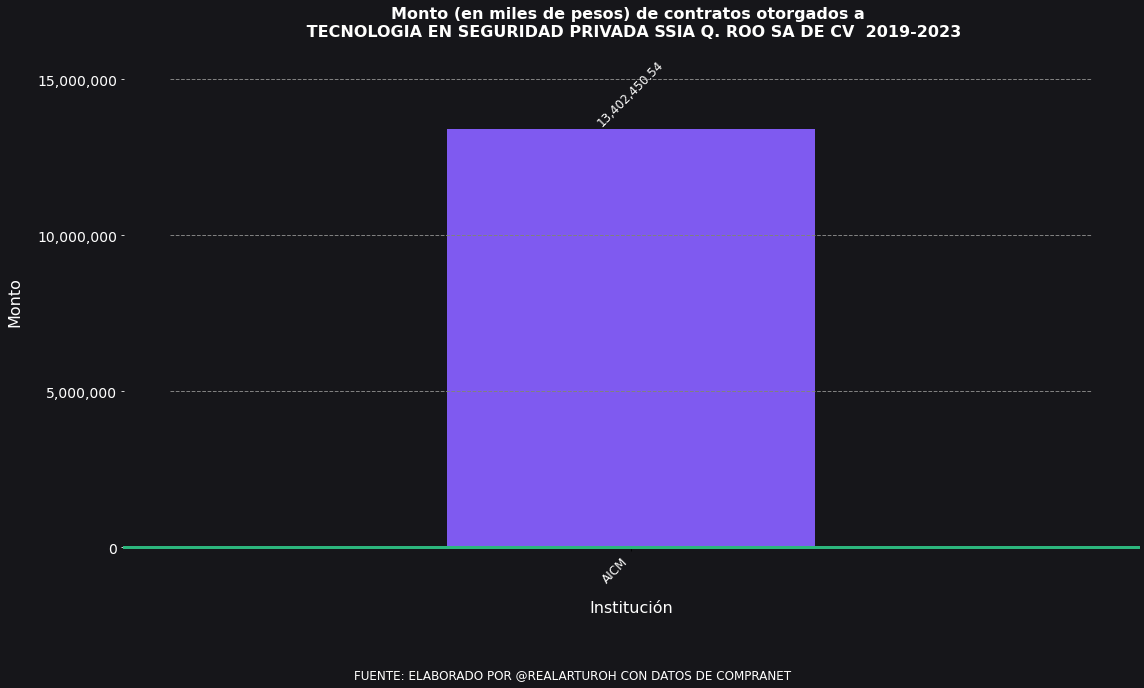

In [25]:
width = max(16, 0.5*len(instituciones))
height = width * (9/16)

fig, ax = plt.subplots(figsize=(width, height))
bars = ax.bar(instituciones, importe, color='#7f5af0')

ax.set_title(f"Monto (en miles de pesos) de contratos otorgados a \n {proveedor}  2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_xlabel("Institución", fontsize=16, labelpad=15, color='#fffffe')
ax.set_ylabel("Monto", fontsize=16, labelpad=15, color='white')

ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(instituciones))))
ax.set_xticklabels(instituciones, fontsize=12, rotation=45, color='#fffffe', ha="right")

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='y', labelsize=14, colors='white')

ax.yaxis.set_major_locator(ticker.MultipleLocator(y_interval))
for y in np.arange(0, max(importe)+y_interval, y_interval):
    plt.hlines(y, xmin=-1, xmax=len(instituciones), colors='gray', linestyles='dashed', linewidth=1)

fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')

for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_color('#2cb67d')

for bar in bars:
    yval = bar.get_height()
    formatted_yval = "{:,.2f}".format(yval)
    ax.text(bar.get_x() + bar.get_width()/2, yval+0.1, formatted_yval, ha='center', va='bottom', fontsize=12, color='#fffffe', rotation=45)

plt.figtext(0.5, -0.08, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


### Resultados de búsqueda por proveedor

In [26]:
# Asumiendo que 'buscar' es tu DataFrame original

# Creando el DataFrame prov_df con sumas de importes
prov_df = buscar.groupby(['proveedor_o_contratista', 'rfc']).agg({'importe':'sum'}).reset_index()
prov_df.sort_values(by='importe', ascending=False, inplace=True)

# Añadiendo la columna 'año_constitucion'
def convert_year(two_digit_year):
    if two_digit_year.isdigit():
        year_int = int(two_digit_year)
        if year_int > 23:
            return "19" + two_digit_year
        else:
            return "20" + two_digit_year
    else:
        return "unknown"

prov_df['año_constitucion'] = prov_df['rfc'].apply(lambda x: convert_year(str(x)[3:5]) if len(str(x)) >= 5 else "unknown")

# 1. Crear una tabla dinámica basada en el importe
pivot_df_importe = buscar.pivot_table(index='proveedor_o_contratista', columns='tipo_de_procedimiento', values='importe', aggfunc='sum', fill_value=0)

# 2. Convertir sumas en porcentajes
pivot_df_percentage = pivot_df_importe.divide(pivot_df_importe.sum(axis=1), axis=0) * 100
pivot_df_percentage.reset_index(inplace=True)

# 3. Fusionar con prov_df
prov_df = pd.merge(prov_df, pivot_df_percentage, on='proveedor_o_contratista', how='left')

# Opcional: mostrar el resultado
pd.options.display.float_format = '{:,}'.format

prov_df

,proveedor_o_contratista,rfc,importe,año_constitucion,ADJUDICACIÓN DIRECTA,CONTRATO ENTRE ENTES PUBLICOS,INVITACIÓN A CUANDO MENOS 3 PERSONAS,LICITACIÓN PÚBLICA,OTRAS CONTRATACIONES
0,TECNOLOGIA EN SEGURIDAD PRIVADA SSIA Q. ROO SA...,TSP090417KQ9,"921,836,640.94",2009,0.0,0.0,0.0,100.0,0.0
1,PROVETECNIA,PRO840815V20,"855,031,640.02",1984,98.37433373112661,0.0,0.0,1.6256662688733798,0.0
2,SERVICIOS INMOBILIARIOS IROA SA DE CV,SII1806112RA,"796,953,180.16",2018,43.655556101821574,0.0,0.0,56.34444389817842,0.0
3,SERVISEG SA DE CV,SER940725D41,"659,875,731.46",1994,0.0,0.0,0.0,100.0,0.0
4,SISTEMAS INTEGRALES PARA EL TRANSPORTE SA DE CV,SIT890317V85,"604,962,829.39",1989,0.0,0.0,0.0,100.0,0.0
...,...,...,...,...,...,...,...,...,...
335,COMERCIAL LEICAM SA DE CV,CLE951113NR4,"10,501.8",1995,0.0,0.0,0.0,100.0,0.0
336,MAYOREO ELECTROMECANICO SA DE CV,MEL821130GYA,"10,082.6",1982,0.0,0.0,0.0,100.0,0.0
337,TECNOLOGIA EN INFORMATICA MULTIPLE SA DE CV,TIM030714AU3,"9,966.43",2003,100.0,0.0,0.0,0.0,0.0
338,SOLUCIONES EN HARDWARE INTELIGENTE SA DE CV,SHI010130GF6,"1,900.0",2001,100.0,0.0,0.0,0.0,0.0


In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

prov_df2 = prov_df
prov_df2.sort_values(by='importe', ascending=True, inplace=True)
prov_df2 = prov_df2.tail(20)

proveedores = prov_df2['proveedor_o_contratista'].values
importe = prov_df2['importe'].values / 1e3  # Convertimos a miles


In [34]:
# Determine the order of magnitude of the max value
magnitude = 10 ** (math.floor(math.log10(max(importe))))

# Adjust the interval based on the magnitude
if max(importe) / magnitude < 2.5:
    x_interval = 0.5 * magnitude
elif max(importe) / magnitude < 5:
    x_interval = magnitude
else:
    x_interval = 2 * magnitude


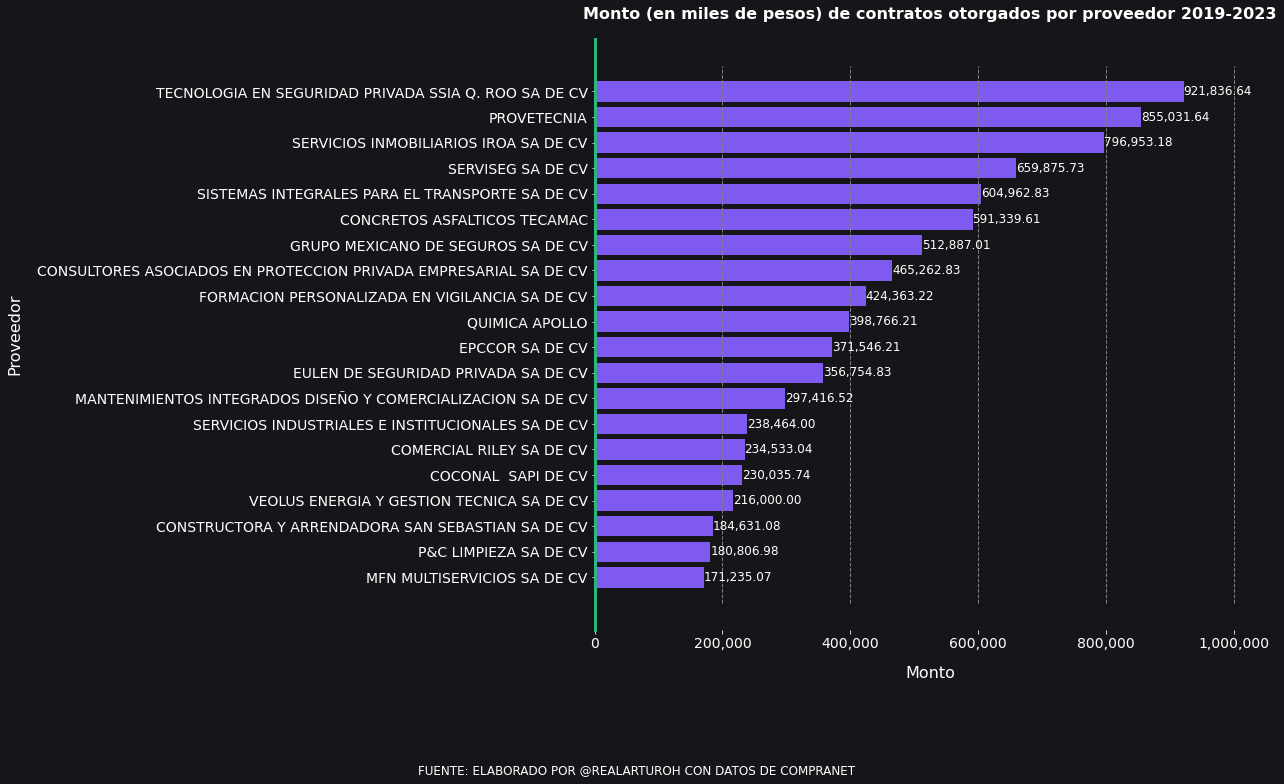

In [35]:
height = max(10, 0.5 * len(proveedores))
width = height * (16/9)

fig, ax = plt.subplots(figsize=(width, height))
bars = ax.barh(proveedores, importe, color='#7f5af0')

ax.set_title(f"Monto (en miles de pesos) de contratos otorgados por proveedor 2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_ylabel("Proveedor", fontsize=16, labelpad=15, color='white')
ax.set_xlabel("Monto", fontsize=16, labelpad=15, color='white')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='x', labelsize=14, colors='white')

ax.xaxis.set_major_locator(ticker.MultipleLocator(x_interval))
for x in np.arange(0, max(importe)+x_interval, x_interval):
    plt.vlines(x, ymin=-1, ymax=len(proveedores), colors='gray', linestyles='dashed', linewidth=1)

fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')

for spine in ['bottom', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('#2cb67d')
ax.tick_params(axis='y', labelsize=14, colors='white')

for bar in bars:
    xval = bar.get_width()
    formatted_xval = "{:,.2f}".format(xval)
    ax.text(xval + 0.1, bar.get_y() + bar.get_height()/2, formatted_xval, ha='left', va='center', fontsize=12, color='#fffffe')

plt.figtext(0.5, -0.08, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()


### Proveedores sospechosos


In [36]:
import datetime

# Año actual
current_year = datetime.datetime.now().year

# Función para calcular la probabilidad de sospecha
def calculate_suspicion(row):
    suspicion_score = 0

    # Si la empresa se constituyó en los últimos 5 años
    if row['año_constitucion'] != 'unknown' and (current_year - int(row['año_constitucion'])) <= 5:
        suspicion_score += 0.5

    # Si más del 50% de su importe proviene de "ADJUDICACIÓN DIRECTA" o "INVITACIÓN A CUANDO MENOS 3 PERSONAS"
    other_value = row.get('OTRO', 0)  # Utiliza 0 si 'OTRO' no existe en la fila
    if row['ADJUDICACIÓN DIRECTA'] + row['INVITACIÓN A CUANDO MENOS 3 PERSONAS'] + other_value > 50:
        suspicion_score += 0.5

    return suspicion_score

# Aplicar la función para calcular la probabilidad de sospecha
prov_df['probabilidad_sospecha'] = prov_df.apply(calculate_suspicion, axis=1)

# Filtrar los proveedores sospechosos
suspicious_providers = prov_df[prov_df['probabilidad_sospecha'] >= 0.5]

# Seleccionar los 20 proveedores sospechosos que más han ganado
top_20_suspicious_providers_df = suspicious_providers.nlargest(20, 'importe')

# Resultado
top_20_suspicious_providers_df


,proveedor_o_contratista,rfc,importe,año_constitucion,ADJUDICACIÓN DIRECTA,CONTRATO ENTRE ENTES PUBLICOS,INVITACIÓN A CUANDO MENOS 3 PERSONAS,LICITACIÓN PÚBLICA,OTRAS CONTRATACIONES,probabilidad_sospecha
1,PROVETECNIA,PRO840815V20,"855,031,640.02",1984,98.37433373112661,0.0,0.0,1.6256662688733798,0.0,0.5
2,SERVICIOS INMOBILIARIOS IROA SA DE CV,SII1806112RA,"796,953,180.16",2018,43.655556101821574,0.0,0.0,56.34444389817842,0.0,0.5
18,P&C LIMPIEZA SA DE CV,PLI0812185H2,"180,806,978.21",2008,100.0,0.0,0.0,0.0,0.0,0.5
22,JET VAN CAR RENTAL SA DE CV,JCR040721NU2,"149,751,468.79000002",2004,100.0,0.0,0.0,0.0,0.0,0.5
24,DESAZOLVE Y CONSTRUCCION DEYCO SA DE CV,DCD9511227A8,"136,625,182.3795",1995,59.01186512311468,0.0,9.351790041538576,31.636344835346737,0.0,0.5
56,TEC PLUSS SA DE CV,TPL030219RE3,"43,188,395.04",2003,100.0,0.0,0.0,0.0,0.0,0.5
75,GEKO GROUP SA DE CV,WME830316NL5,"21,070,691.0",1983,22.216124758319506,0.0,44.12005282598468,33.66382241569581,0.0,0.5
79,JOMTEL TELECOMUNICACIONES SA DE CV,JTE980210IT8,"18,620,689.56",1998,100.0,0.0,0.0,0.0,0.0,0.5
82,OBRAS VIALES Y SEÑALIZACIONES SA DE CV,OVS041008711,"17,966,385.0",2004,100.0,0.0,0.0,0.0,0.0,0.5
90,RETO INDUSTRIAL SA DE CV,RIN890824FMA,"15,135,886.2",1989,100.0,0.0,0.0,0.0,0.0,0.5


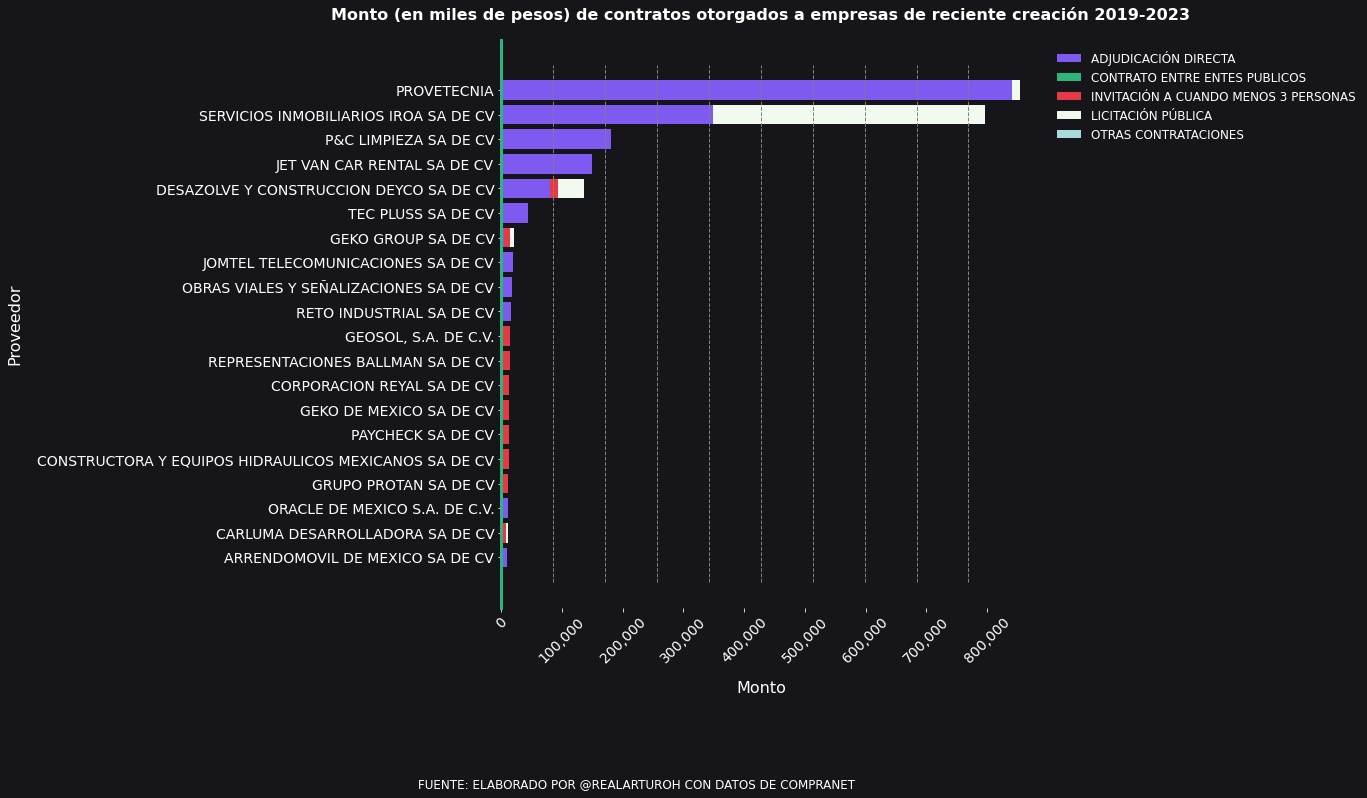

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

top20df = top_20_suspicious_providers_df.sort_values(by='importe', ascending=True)
top20df['importe'] = top20df['importe']/1000

# Datos
proveedores = top20df['proveedor_o_contratista'].tolist()
tipos_procedimiento = ['ADJUDICACIÓN DIRECTA', 'CONTRATO ENTRE ENTES PUBLICOS', 'INVITACIÓN A CUANDO MENOS 3 PERSONAS', 'LICITACIÓN PÚBLICA', 'OTRAS CONTRATACIONES', 'OTRO']

# Calcular los importes por tipo de procedimiento en función de los porcentajes y el importe total
colors = ['#7f5af0', '#2cb67d', '#e63946', '#f1faee', '#a8dadc', '#457b9d']

data_procedimientos = []
tipos_presentes = []
colores_presentes = []
for i, tipo in enumerate(tipos_procedimiento):
    if tipo in top20df.columns: # Verifica si el tipo de procedimiento existe en el DataFrame
        importe_tipo = (top20df[tipo] / 100) * top20df['importe']
        data_procedimientos.append(importe_tipo.values)
        tipos_presentes.append(tipo)
        colores_presentes.append(colors[i % len(colors)])


# Tamaño de la figura
height = max(10, 0.5 * len(proveedores))
width = height * (16/9)

fig, ax = plt.subplots(figsize=(width, height))

# Generar las barras apiladas
bars = []
for i, data in enumerate(data_procedimientos):
    bars.append(ax.barh(proveedores, data, left=[sum(data_procedimientos[j][k] for j in range(i)) for k in range(len(data))], color=colores_presentes[i]))


# Configuración del gráfico
ax.set_title(f"Monto (en miles de pesos) de contratos otorgados a empresas de reciente creación 2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_ylabel("Proveedor", fontsize=16, labelpad=15, color='white')
ax.set_xlabel("Monto", fontsize=16, labelpad=15, color='white')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='x', labelsize=14, colors='white', rotation=45)
x_interval = (top20df['importe'].max() / 10)
for x in np.arange(0, top20df['importe'].max() + x_interval, x_interval):
    plt.vlines(x, ymin=-1, ymax=len(proveedores), colors='gray', linestyles='dashed', linewidth=1)
fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')
for spine in ['bottom', 'right', 'top']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('#2cb67d')
ax.tick_params(axis='y', labelsize=14, colors='white')
legend = ax.legend(bars, tipos_presentes, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left') # Usa los tipos de procedimiento presentes
frame = legend.get_frame()
frame.set_alpha(0)
for text in legend.get_texts():
    text.set_color('white')
    
plt.figtext(0.5, -0.1, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, right=0.8)
plt.show()
